In [1]:

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\HP\anaconda3\envs\image-caption\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\anaconda3\envs\image-caption\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\anaconda3\envs\image-caption\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\anaconda3\envs\image

In [2]:
# load data into memory
def load_data(filename):
    file1 = open(filename, 'r')
    text = file1.read()
    file1.close()
    return text

filename = r"data/Flickr8k_text/Flickr8k.token.txt"
data = load_data(filename)
print(data[:300])
#print all the image descriptions

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
#Loading descriptions
def load_descriptions(data):
    mapping = dict()
    for line in data.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        # description tokens to string conversion
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(data)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [7]:
print(descriptions['1019077836_6fc9b15408'])

['A brown dog chases the water from a sprinkler on a lawn .', 'a brown dog plays with the hose .', 'A brown dog running on a lawn near a garden hose', 'A dog is playing with a hose .', 'Large brown dog running away from the sprinkler in the grass .']


In [10]:
#cleaning description strings
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [12]:
print(descriptions['1019077836_6fc9b15408'])

['brown dog chases the water from sprinkler on lawn', 'brown dog plays with the hose', 'brown dog running on lawn near garden hose', 'dog is playing with hose', 'large brown dog running away from the sprinkler in the grass']


In [11]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file1 = open(filename, 'w')
    file1.write(data)
    file1.close()

save_descriptions(descriptions, 'descriptions.txt')

In [14]:
def load_set(filename):
    data = load_data(filename)
    dataset = list()
    for line in data.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset
filename = r'data/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [16]:
print(train)

{'449352117_63c359c6e7', '2525232298_cf42d415ab', '3246190363_68d903bfcb', '3547313700_39368b9a2f', '1308472581_9961782889', '3500399969_f54ce5848f', '3271061953_700b96520c', '3173215794_6bdd1f72d4', '2883324329_24361e2d49', '2503629305_055e9ec4b1', '954987350_a0c608b467', '2959737718_31203fddb5', '252578659_9e404b6430', '2786299623_a3c48bd318', '2363540508_9dd1ccf7c7', '3292016893_24d14c8b4f', '3323419265_7fefaa9d5d', '2549452277_873cb80d3e', '3533922605_a2b1e276f6', '3286045254_696c6b15bd', '3516653997_98ec551a67', '441817653_fbdf83060b', '2685752892_9d5cd7f274', '2746072388_b127f8259b', '3551447084_becc6a4666', '2415265825_fbfe0c8556', '3319405494_58dee86b21', '3326273086_e09e845185', '444872454_9f51e07f88', '3084731832_8e518e320d', '242064301_a9d12f1754', '2784625888_71a421e171', '487071033_27e460a1b9', '3595216998_0a19efebd0', '109671650_f7bbc297fa', '2713554148_64cd465e71', '3506096155_13632955e8', '496380034_d22aeeedb3', '3207676216_48478bce97', '2635908229_b9fc90d3fb', '3717531

In [18]:
images = r'data/Flicker8k_Dataset/'
img = glob.glob(images + '*.jpg')

In [19]:
#train data
train_images_file = r'data/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# list of training images paths
train_img = []

for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [20]:
print(train_img[:5])

['data/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg', 'data/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg', 'data/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg', 'data/Flicker8k_Dataset\\1003163366_44323f5815.jpg', 'data/Flicker8k_Dataset\\1007129816_e794419615.jpg']


In [21]:
#test data
test_images_file = r'data/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images:
        test_img.append(i) 

In [22]:
def load_clean_descriptions(filename, dataset):
	data = load_data(filename)
	descriptions = dict()
	for line in data.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [23]:
# converting images to a common size (299*299)
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [18]:

model = InceptionV3(weights='imagenet')

In [19]:
!pip install h5py==2.10.0

In [20]:
import h5py
print(h5py.__version__)

2.10.0


In [21]:
model_new = Model(model.input, model.layers[-2].output)

In [22]:
def encode(image):
    image = preprocess(image)  
    feature_vector = model_new.predict(image) 
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])
    return feature_vector

In [23]:
#encoding images to obtain feature vector
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

KeyboardInterrupt: 

In [24]:
import pickle
with open("data/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [55]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 831.4113669395447


In [26]:
with open("data/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [27]:
train_features = load(open("data/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=1624


In [28]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [29]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [30]:
ixtoword = {} 
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 
vocab_size

1652

In [32]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [33]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pading the input images
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [34]:
#downloading glove vectors
glove_dir = 'glove'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [35]:
embedding_dim = 200

#getting a 200 dimension vector for the vocab
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(1652, 200)

In [37]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [39]:
model.layers[2]

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
epochs = 150
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

Epoch 1/1
  19/2000 [..............................] - ETA: 48:52 - loss: 6.3405

KeyboardInterrupt: 

In [50]:
model.load_weights('model_weights/model_149.h5')

In [51]:
images = 'data/Flicker8k_Dataset/'

In [52]:
with open("data/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [53]:
def imageSearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

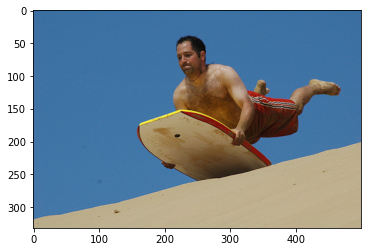

Image with Caption: man in swim trunks kicking football where ball


In [56]:
pic = list(encoding_test.keys())[996]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image with Caption:",imageSearch(image))